In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Users/user/Desktop/DTP/creditcard.csv")

# Preview the data
print(df.head())

# Check data types and null values
print(df.info())

# Check class distribution
print(df['Class'].value_counts())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

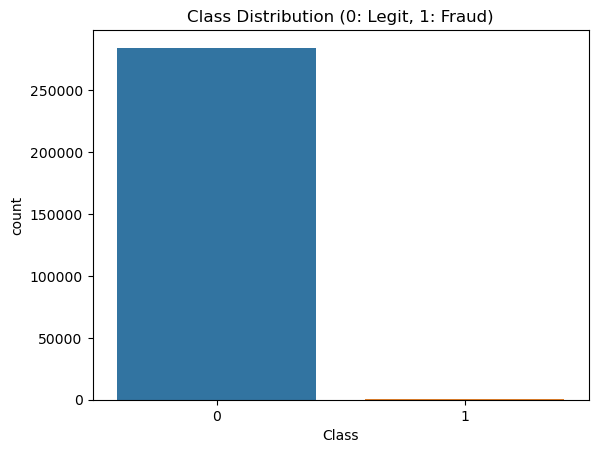

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.show()




In [6]:
plt.figure(figsize=(10,5))
sns.histplot(class_0_amounts, bins=50, color='blue', label='Legit', alpha=0.6)
sns.histplot(class_1_amounts, bins=50, color='red', label='Fraud', alpha=0.6)
plt.legend()
plt.title('Transaction Amount Distribution by Class (No Log Scale)')
plt.show()


NameError: name 'class_0_amounts' is not defined

<Figure size 1000x500 with 0 Axes>

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


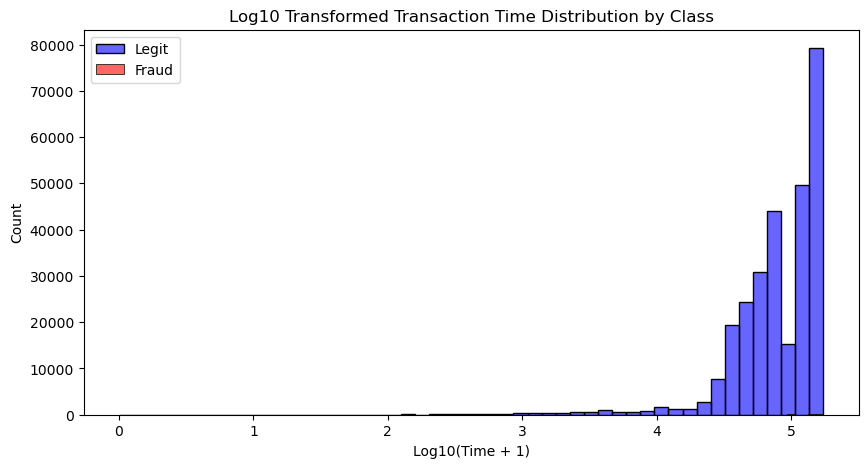

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,5))

# Extract the data
class_0_time = df[df['Class'] == 0]['Time']
class_1_time = df[df['Class'] == 1]['Time']

# Add small constant to avoid log(0)
class_0_log_time = np.log10(class_0_time + 1)
class_1_log_time = np.log10(class_1_time + 1)

# Plot histograms for each class
sns.histplot(class_0_log_time, bins=50, color='blue', label='Legit', alpha=0.6)
sns.histplot(class_1_log_time, bins=50, color='red', label='Fraud', alpha=0.6)

plt.legend()
plt.title('Log10 Transformed Transaction Time Distribution by Class')
plt.xlabel('Log10(Time + 1)')
plt.show()


Step 4: Handle Imbalanced Data
The dataset is imbalanced (fraud = 492 out of 284,807). We’ll use SMOTE (Synthetic Minority Over-sampling Technique) to oversample fraud cases in the training set.

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale Time and Amount (important before SMOTE)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split into train-test (stratify to keep class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: Class
0    199020
1       344
Name: count, dtype: int64
After SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


Model Selection and Training


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Example: Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_smote, y_train_smote)


LogisticRegression(max_iter=1000, random_state=42)

 Evaluation Metrics

In [6]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Predict on test set
y_pred = model_lr.predict(X_test)
y_proba = model_lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc_auc)

# Precision-Recall curve AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC: 0.9660413065624391
Precision-Recall AUC: 0.7444891644058276


 Model Tuning (GridSearch example for Random Forest)

 Final Evaluation on Test Set
python



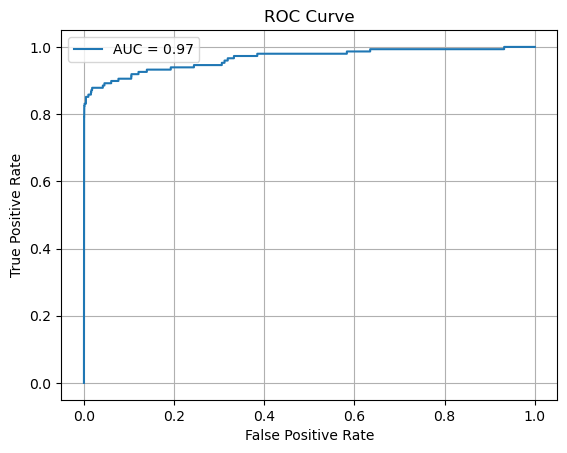

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


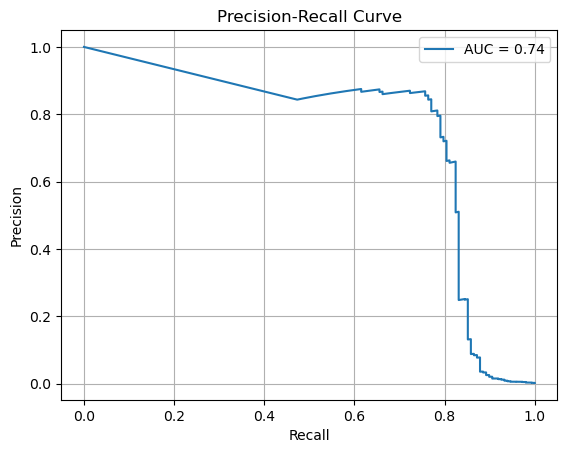

In [8]:
plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

# Assume you have X_train and y_train (with all 30 features)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [12]:
# Save the whole pipeline
joblib.dump(pipeline, "fraud_model_pipeline.pkl")


['fraud_model_pipeline.pkl']

In [13]:
import os
print(os.getcwd())



C:\Users\user
